Проверим гипотезу о независимости результативности баскетболистов в зависимости от места проведения матча. Прежде всего определим результативность как отношение числа успешных бросков к числу попыток бросков, то есть в пределе $~-$ вероятность успеха броска.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from statsmodels.stats.descriptivestats import sign_test
from permute.core import one_sample

In [2]:
path = 'https://raw.githubusercontent.com/Natalia-Varenik/psad-2020/master/lab/lab1/data/nba.csv'
data = pd.read_csv(path, index_col=0)

In [3]:
data['p_home'] = data.score_home / data.atm_home
data['p_away'] = data.score_away / data.atm_away
p_home = data['p_home'].values
p_away = data['p_away'].values

In [28]:
probs = np.concatenate([p_home, p_away])
is_home = np.concatenate([np.ones_like(p_home), np.zeros_like(p_away)])
probs_df = pd.DataFrame(data=np.stack([probs, is_home], axis=1), columns=['prob', 'is_home'])
probs_df['is_home'] = probs_df['is_home'].astype(int)
probs_df[''] = '' # placeholder for violin hue

Визуально рассмотрим распределение данных на предмет похожести и наличия выбросов.
Можно заметить, что распредления результативности схожи в домашних и выездных матчах. По боксплотам делаем вывод о наличии выбросов в данных, далее выкидываем игроков, показатели которых соответсвуют выбросам.

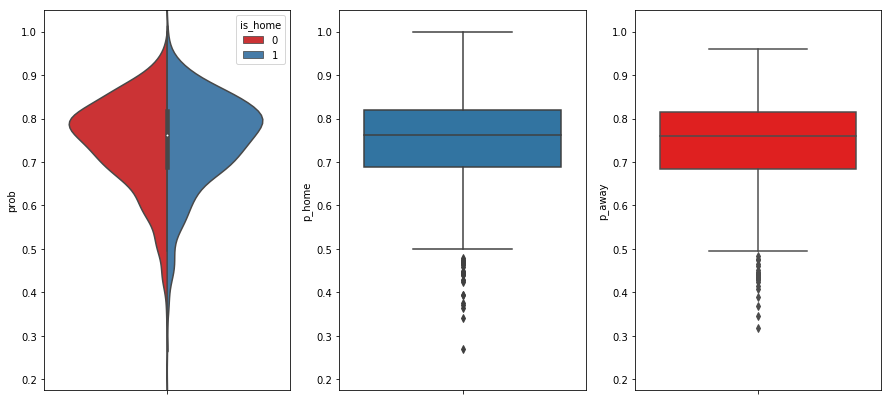

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
axs[0].set_ylim((0.175, 1.05))
sns.violinplot(x='', y='prob', hue='is_home', data=probs_df, palette="Set1", split=True, ax=axs[0])
axs[1].set_ylim((0.175, 1.05))
sns.boxplot(y=data['p_home'], ax=axs[1])
axs[2].set_ylim((0.175, 1.05))
sns.boxplot(y=data['p_away'], ax=axs[2], color='red');

In [35]:
# filter out outliers via boxplot rule
low_bound_home = np.quantile(data['p_home'], 0.25) - 1.5 * st.iqr(data['p_home'])
low_bound_away = np.quantile(data['p_away'], 0.25) - 1.5 * st.iqr(data['p_away'])
data_for_test = data[(data['p_home'] >= low_bound_home) & (data['p_away'] >= low_bound_away)]

Для проверки гипотезы независимости воспользуемся критерием Хи-квадрат для гипотезы независимости. Для этого вычислим соответствующую таблицу сопряжённости, разбив данные по бинам. Данный тест здесь вполне применим, поскольку данных достаточно много, чтобы выполнились условия его применимости.

In [47]:
bins = 10
obs_array = np.array([data_for_test['p_home'].values, data_for_test['p_away'].values])
thresholds = np.linspace(obs_array.min(), 1.0, bins)
cont_table = np.zeros((2, len(thresholds)-1))
for i in range(len(thresholds) - 1):
    low = thresholds[i]
    upper = thresholds[i+1]
    mask = (obs_array >= low) & (obs_array < upper)
    cont_table[0][i] = mask.sum(axis=1)[0]
    cont_table[1][i] = mask.sum(axis=1)[1]

Перепроверим условия применимости критерия. <br/>
Общее число испытаний явно достаточно, осталось убедиться, что число объектов в каждом бине не менее 5.

In [62]:
# check if nu_ij>=5 for all i, j
assert np.sum(cont_table >= 5) == np.prod(cont_table.shape)
print("Contingency table for chi2 test:\n", cont_table)

Contingency table for chi2 test:
 [[ 21.  45.  68. 150. 193. 223. 149.  43.   5.]
 [ 27.  48.  76. 145. 197. 235. 128.  38.   5.]]


In [66]:
pval = st.chi2_contingency(cont_table)[1]
print("p-val for chi2 test: %.03f"%pval)

p-val for chi2 test: 0.889


Как видим, гипотеза независимости не отвергается на уровне значимости $\alpha=0.05$.

Перейдем к определению доли игроков, для которых разница в результативности существенна. На гистограмм распредлений данных и результатов теста введем допущение о том, что результативность в общем случае не зависит от места проведения матча. Далее исходим из этого предположения. 

Рассмотрим разность результативностей в домашних и выездных играх для баскетболистов.

In [67]:
diffs = p_home - p_away

С учетом данного допущения эта величина описывает разность результативностей игроков в независимых условиях. Распределение, ею задаваемое, соответствует распределению дельты в независимых испытаниях (играх).

Объекты, являющиеся выбросами (не пренадлежащими этому распредлению), могут трактоваться как объекты, для которых не имеет место независимость результативности в выездных и домашних играх. Таким образом, для этих объектов имеет место _существенная_ разница в показателях результативности.

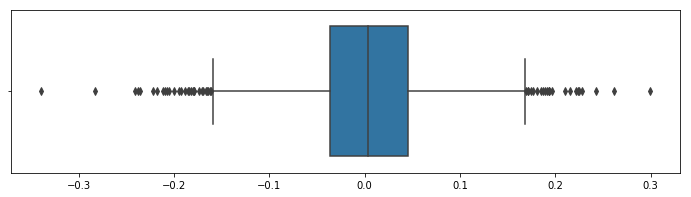

In [69]:
plt.figure(figsize=(12, 3))
sns.boxplot(diffs);

In [86]:
low_bound = np.quantile(diffs, 0.25) - 1.5 * st.iqr(diffs)
up_bound = np.quantile(diffs, 0.75) + 1.5 * st.iqr(diffs)
mask = (diffs < low_bound) | (diffs > up_bound)
print("Доля игроков, разница в результативности которых существенна: %.02f" % (100 * mask.mean()), "%")

Доля игроков, разница в результативности которых существенна: 5.56 %


Таким образом, гипотеза независимости результативности игроков от места проведения матча не отклоняется, что согласуется с первоначальными представлениями полученными на этапе рассмотрения данных. 

Доля игроков, для которых результатинвость существенно различается, была определена через множество объектов, являющихся выбросами относительно распределения разности результативностей с учетом дорущения о независимости результативности игроков в общем случае. 